# Fruit Classification | Suppressing Varieties And Oversampling

This project uses a [Kaggle dataset](https://www.kaggle.com/datasets/moltean/fruits) with fruit images in order to create a model that is able to recognise them. 

This dataset includes photos of many different fruits and a bunch of different varieties of each. Therefore, we were forced to reduce the amount of samples, choosing to keep three pairs of similar fruits - Apples and Tomatoes, Kiwis and Cocos and Lemons and Oranges - and all the different varieties of each. 

More than comparing results of different learning algorithms, our goal will also be to test different manipulations on the dataset - ignoring fruit varieties or not, undersampling and oversampling, and others that we may find insightful.

## Dataset Description

In [50]:
import os
import random
import matplotlib.pyplot as plt

In [51]:
BASE_DATASET_PATH = './dataset'
TRAIN_DATASET_PATH = BASE_DATASET_PATH + '/Training'
TEST_DATASET_PATH = BASE_DATASET_PATH + '/Test'

In [52]:
def load_images(path: str, category_transformation) -> dict:
    images = {}
    
    for folder in os.listdir(path):
        category = category_transformation(folder)
        folder = path + '/' + folder
        if category not in images.keys(): images[category] = []
        images[category].append([folder + '/' + file for file in os.listdir(folder)])
        
    return images

def load_dataset_images(category_transformation = lambda category: category):
    train = load_images(TRAIN_DATASET_PATH, category_transformation)
    test = load_images(TEST_DATASET_PATH, category_transformation)
    return list(train.keys()), train, test

def load_dataset_images_debug(categories, train_images, test_images):
    train_samples = { category: sum([len(ims) for ims in images]) for category, images in train_images.items() }
    test_samples = { category: sum([len(ims) for ims in images]) for category, images in test_images.items() }

    print('Train Dataset', train_samples, sep='\n', end='\n\n')
    print('Test Dataset', test_samples, sep='\n')

    fig, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(15, 5))

    ax_train.bar(categories, [ sum([len(ims) for ims in images]) for category, images in train_images.items() ])
    ax_train.set_title('Train Dataset')
    ax_train.set_xlabel('Fuits')
    ax_train.set_ylabel('Samples #')

    ax_test.bar(categories, [ sum([len(ims) for ims in images]) for category, images in test_images.items() ])
    ax_test.set_title('Test Dataset')
    ax_test.set_xlabel('Fuits')
    ax_test.set_ylabel('Samples #')

    plt.show()

Train Dataset
{'Apple': 6404, 'Tomato': 5103, 'Orange': 479, 'Cocos': 490, 'Kiwi': 466, 'Lemon': 982}

Test Dataset
{'Apple': 2134, 'Tomato': 1707, 'Orange': 160, 'Cocos': 166, 'Kiwi': 156, 'Lemon': 330}


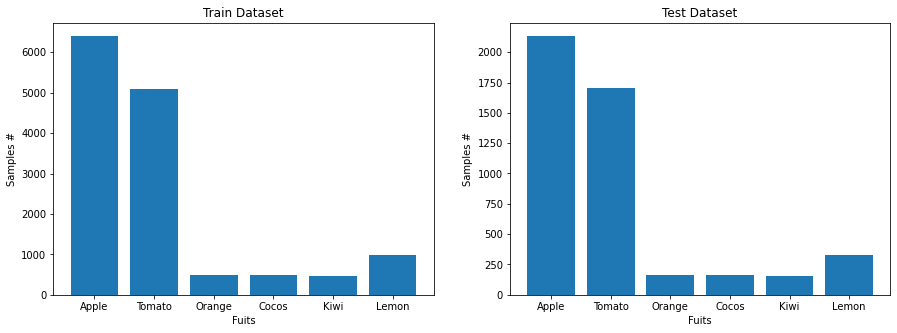

In [53]:
categories, train_images, test_images = load_dataset_images(lambda folder: folder.split()[0])

# Debugging information
load_dataset_images_debug(categories, train_images, test_images)

## Balance Dataset

In [54]:
# Balance training dataset
max_number_collections = max([ len(collections) for collections in train_images.values() ])
min_number_samples = 1500
train_images_balanced = { category: [ image for collection in collections for image in random.sample(collection, min([int(min_number_samples/len(collections)), len(collection)])) ] for category, collections in train_images.items() }
train_images_balanced = { category: images + random.sample([image for collection in train_images[category] for image in collection if image not in train_images_balanced[category]], min([min_number_samples - len(train_images_balanced[category]), len([image for collection in train_images[category] for image in collection]) - len(train_images_balanced[category])])) for category, images in train_images_balanced.items() }

Train Dataset
{'Apple': 1500, 'Tomato': 1500, 'Orange': 1500, 'Cocos': 1500, 'Kiwi': 1500, 'Lemon': 1500}

Test Dataset
{'Apple': 2134, 'Tomato': 1707, 'Orange': 450, 'Cocos': 450, 'Kiwi': 450, 'Lemon': 450}


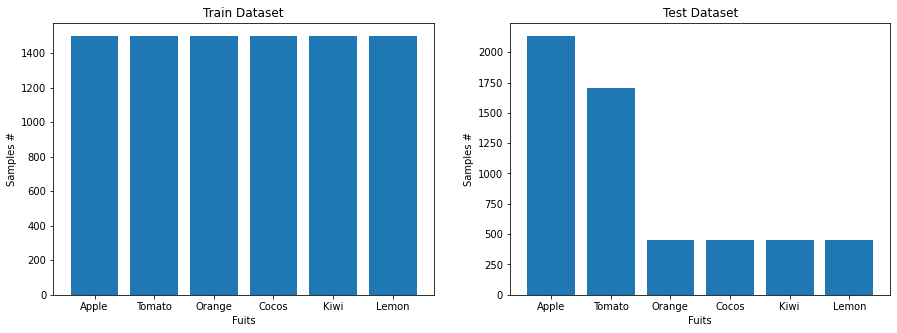

In [55]:
# Format datasets
train_dataset = train_images_balanced
test_dataset = { category: [ image for collection in collections for image in collection ] for category, collections in test_images.items() }

for category, images in train_dataset.items():
    while len(images) < min_number_samples:
        train_dataset[category].extend([image for collection in train_images[category] for image in collection][:min_number_samples-len(images)])
        
for category, images in test_dataset.items():
    while len(images) < int(min_number_samples*.3):
        test_dataset[category].extend([image for collection in test_images[category] for image in collection][:int(min_number_samples*.3)-len(images)])

# Debugging information
load_dataset_images_debug(categories, { category: [images] for category, images in train_dataset.items() }, { category: [images] for category, images in test_dataset.items() })

In [43]:
import matplotlib.image as mpimg

In [44]:
def load_image_files(data):
    return { category: [ mpimg.imread(image) for image in images ] for category, images in data.items() }

def load_image_files_debug(categories, data, subtitle=''):
    fig, axs = plt.subplots(1, len(categories), figsize=(18, 3), dpi=180)
    fig.suptitle('Fruits' + (' | ' + subtitle) if subtitle else '')

    for idx in range(len(categories)):
        category = categories[idx]
        print('Shape of first "{}" image -'.format(category), data[category][0].shape)
        axs[idx].imshow(data[category][0])
        axs[idx].set_title(category)

./dataset/Training/Tomato 1/r_196_100.jpg
Shape of first "Apple" image - (100, 100, 3)
Shape of first "Tomato" image - (100, 100, 3)
Shape of first "Orange" image - (100, 100, 3)
Shape of first "Cocos" image - (100, 100, 3)
Shape of first "Kiwi" image - (100, 100, 3)
Shape of first "Lemon" image - (100, 100, 3)
Shape of first "Apple" image - (100, 100, 3)
Shape of first "Tomato" image - (100, 100, 3)
Shape of first "Orange" image - (100, 100, 3)
Shape of first "Cocos" image - (100, 100, 3)
Shape of first "Kiwi" image - (100, 100, 3)
Shape of first "Lemon" image - (100, 100, 3)


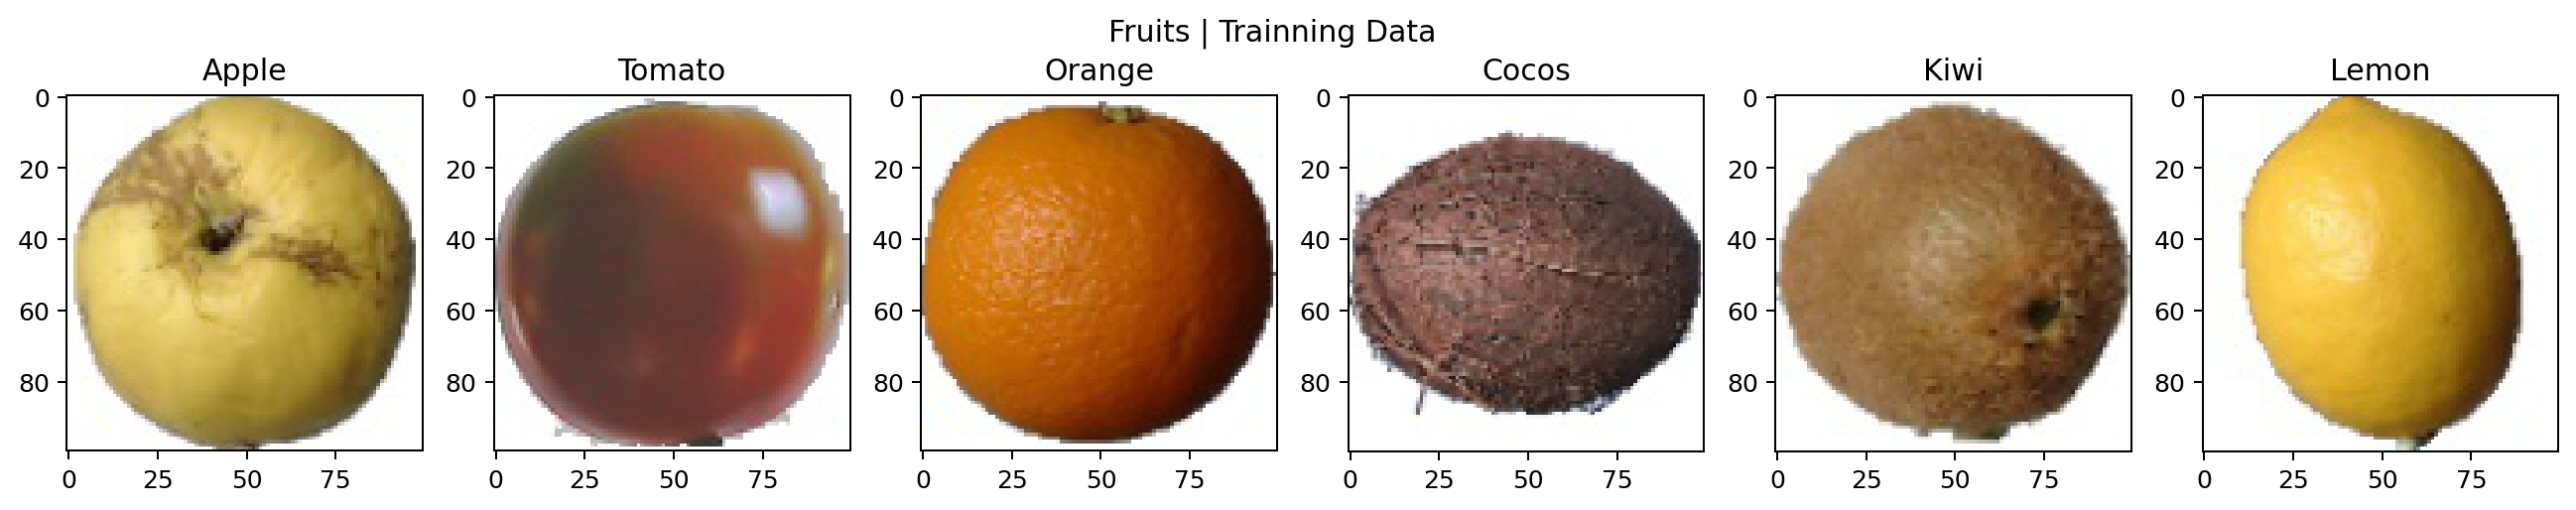

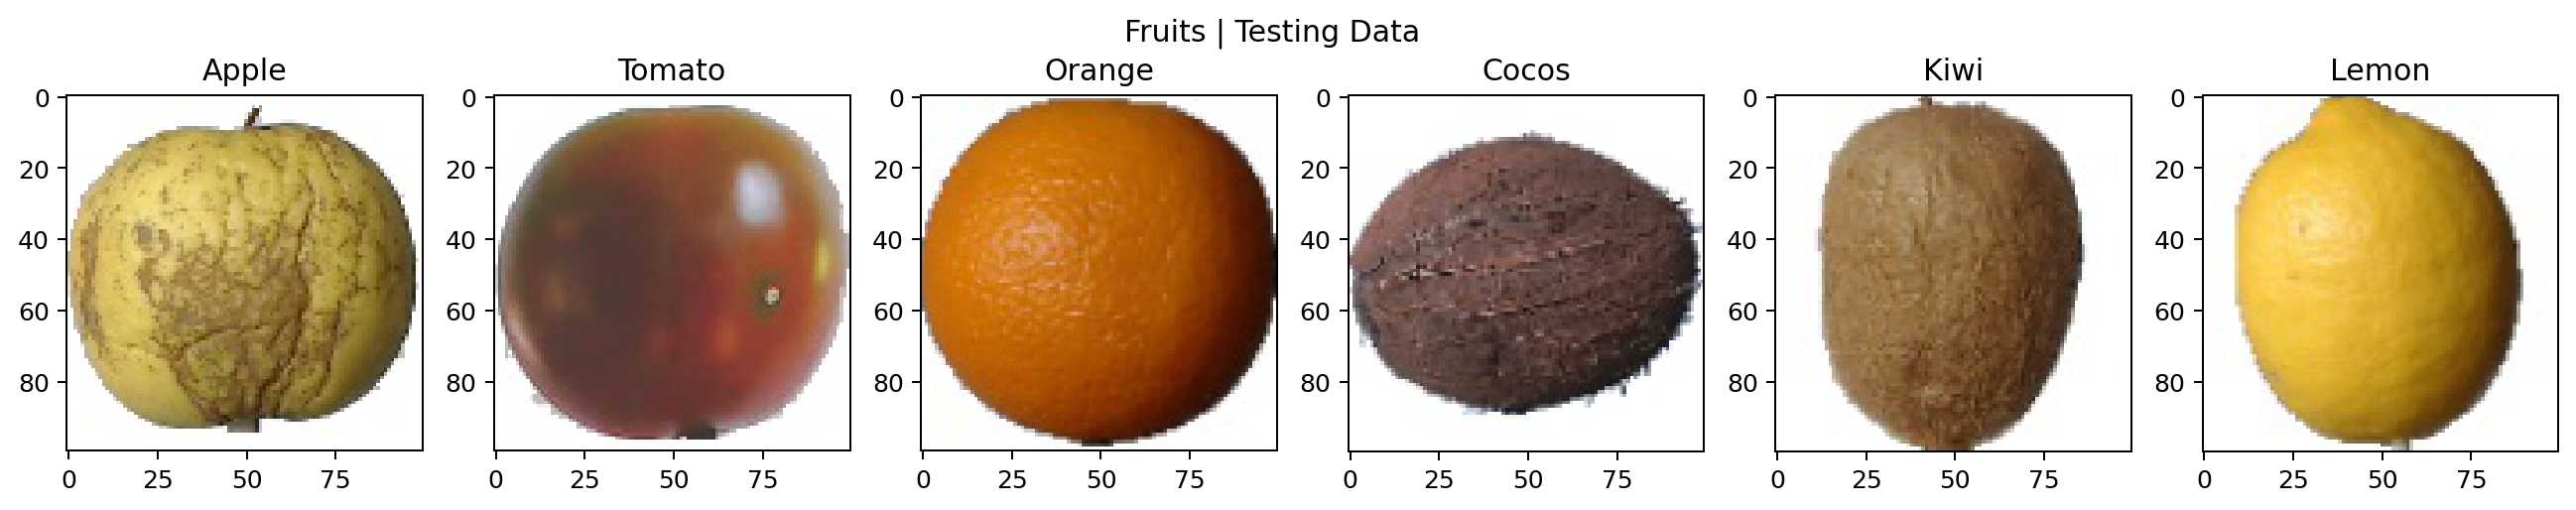

In [56]:
train_dataset_images = load_image_files(train_dataset)
test_dataset_images = load_image_files(test_dataset)

# Debug Training Dataset Information
load_image_files_debug(categories, train_dataset_images, 'Trainning Data')
load_image_files_debug(categories, test_dataset_images, 'Testing Data')

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler    

In [58]:
def decomposition(dataset):
    X_dataset = []
    y_dataset = []
    
    for category, images in dataset.items():
        X_dataset.extend(images)
        y_dataset.extend([category for _ in range(len(images))])
    
    scaler = StandardScaler()
    X_dataset = scaler.fit_transform([i.flatten() for i in X_dataset])
    
    return X_dataset, y_dataset

In [59]:
X_train, y_train = decomposition(train_dataset_images)
X_test, y_test = decomposition(test_dataset_images)

# Debugging info
print("Train data")
print("X length: ", len(X_train))
print("y length: ", len(y_train))

print()

print("Test data")
print("X length: ", len(X_test))
print("y length: ", len(y_test))

Train data
X length:  9000
y length:  9000

Test data
X length:  5641
y length:  5641


## Principal Component Analysis

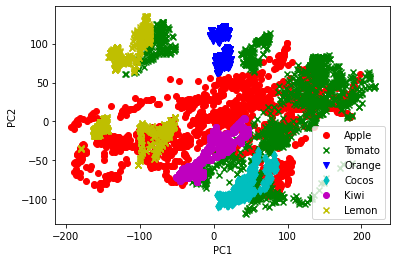

In [60]:
pca = PCA(n_components=2)
dataIn2D = pca.fit_transform(X_train)

colors = {'Apple': 'r', 'Tomato': 'g', 'Orange': 'b', 'Cocos': 'c', 'Kiwi': 'm', 'Lemon': 'y'}
markers = {'Apple': 'o', 'Tomato': 'x', 'Orange': 'v', 'Cocos': 'd', 'Kiwi': 'o', 'Lemon': 'x'}

categories = list(train_dataset_images.keys())

for i in range(len(categories)):
    start = i*len(train_dataset_images[categories[i]])
    end = start+len(train_dataset_images[categories[i]])
    plt.scatter(dataIn2D[start:end,0], dataIn2D[start:end,1], color=colors[categories[i]], marker=markers[categories[i]], label=categories[i])

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

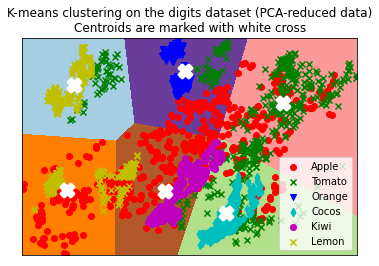

In [14]:
import numpy as np
from sklearn.cluster import KMeans

kmeans = KMeans(init="k-means++", n_clusters=len(categories), n_init=4)
kmeans.fit(dataIn2D)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = dataIn2D[:, 0].min() - 1, dataIn2D[:, 0].max() + 1
y_min, y_max = dataIn2D[:, 1].min() - 1, dataIn2D[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
for i in range(len(categories)):
    start = i*len(train_dataset_images[categories[i]])
    end = start+len(train_dataset_images[categories[i]])
    plt.scatter(dataIn2D[start:end,0], dataIn2D[start:end,1], color=colors[categories[i]], marker=markers[categories[i]], label=categories[i])
    
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    color="w", 
    marker="X",
    s=169,
    linewidths=3,
    zorder=10
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.legend()
plt.show()

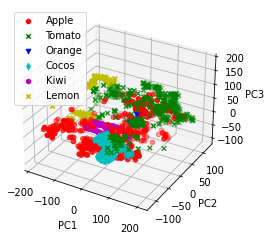

In [15]:
pca = PCA(n_components=3)
dataIn3D = pca.fit_transform(X_train)

colors = {'Apple': 'r', 'Tomato': 'g', 'Orange': 'b', 'Cocos': 'c', 'Kiwi': 'm', 'Lemon': 'y'}
markers = {'Apple': 'o', 'Tomato': 'x', 'Orange': 'v', 'Cocos': 'd', 'Kiwi': 'o', 'Lemon': 'x'}

categories = list(train_dataset_images.keys())
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(len(categories)):
    start = i*len(train_dataset_images[categories[i]])
    end = start+len(train_dataset_images[categories[i]])
    ax.scatter(dataIn3D[start:end,0], dataIn3D[start:end,1], dataIn3D[start:end,2], color=colors[categories[i]], marker=markers[categories[i]], label=categories[i])

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend()

## Training - SVC

In [61]:
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, f1_score,roc_curve,accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn import preprocessing

In [ ]:
clf = SVC(gamma='auto', kernel='linear', probability=True)
clf.fit(X_train, y_train) 


plot_confusion_matrix(clf, X_test, y_test, normalize='true')  
plt.show()

y_pred = clf.predict(X_test)

#Evaluation
precision = accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision))

# calculate the FPR and TPR for all thresholds of the classification
probs = clf.predict_proba(X_test)
probs = probs[:, 1]

In [18]:
y_score = clf.fit(X_train, y_train).decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

#labels = preprocessing.label_binarize(y_test, classes=[i for i in range(len(y_test))])
#print(labels)
#svm_fpr, svm_tpr, thresholds = roc_curve([i for i in range(len(y_test))], probs)
#svm_auc = roc_auc_score(y_test, probs)

ValueError: multiclass format is not supported

### K-Fold

In [19]:
pred_kfold = cross_val_score(clf, X_train, y_train, cv=5) 
print("Accuracy with SVM and K-FOLD CROSS VALIDATION: %0.2f (+/- %0.2f)" % (pred_kfold.mean(), pred_kfold.std() * 2))

Accuracy with SVM and K-FOLD CROSS VALIDATION: 0.90 (+/- 0.04)


## Training - Deep Learning

In [3]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.utils import np_utils

2022-06-26 12:53:44.049615: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-26 12:53:44.049678: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [29]:
def get_model(
    n_classes,
    conv_layers=4, filters_start=16, filters_iteraction_func=lambda f: f*2, input_shape=(100,100,3), 
    kernel_size=2, activation_func='relu', padding='same', pool_size=2, conv_dropout=.3, result_dropout=.4 
):
    model = Sequential()
    
    conv_args = { 'kernel_size':kernel_size, 'activation':activation_func, 'padding':padding }
    
    filters = filters_start
    for i in range(conv_layers):
        args = { 'filters':filters, **conv_args }
        if i == 0: args = { 'input_shape':input_shape, **args }
            
        model.add(Conv2D(**args))
        model.add(MaxPooling2D(pool_size=pool_size))
            
        filters = filters_iteraction_func(filters)
        
    if conv_dropout is not None: model.add(Dropout(conv_dropout))
    model.add(Flatten())
    if result_dropout is not None: model.add(Dropout(result_dropout))
    model.add(Dense(n_classes,activation='softmax'))
    
    return model

def get_compiled_model(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'], **model_args):
    model = get_model(**model_args)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics) 
    
    return model

def get_train_function(batch_size = 32, epochs=30, shuffle=True, **model_args):
    model = get_compiled_model(**model_args)
    return model, lambda X_train, y_train, X_test, y_test: model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_test, y_test),verbose=2,shuffle=shuffle)

In [30]:
model, fit = get_train_function(n_classes=len(categories))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 100, 100, 16)      208       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 50, 50, 32)        2080      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 25, 25, 64)        8256      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 12, 12, 64)      

In [31]:
history = fit(train_data, transfomed_label_train, test_data, transfomed_label_test)

Epoch 1/30
88/88 - 13s - loss: 3.8488 - accuracy: 0.7185 - val_loss: 0.3688 - val_accuracy: 0.8594 - 13s/epoch - 152ms/step
Epoch 2/30
88/88 - 12s - loss: 0.1864 - accuracy: 0.9396 - val_loss: 0.0417 - val_accuracy: 0.9852 - 12s/epoch - 135ms/step
Epoch 3/30
88/88 - 12s - loss: 0.0997 - accuracy: 0.9742 - val_loss: 0.0186 - val_accuracy: 0.9936 - 12s/epoch - 138ms/step
Epoch 4/30
88/88 - 12s - loss: 0.1031 - accuracy: 0.9757 - val_loss: 0.0141 - val_accuracy: 0.9983 - 12s/epoch - 135ms/step
Epoch 5/30
88/88 - 13s - loss: 0.0505 - accuracy: 0.9857 - val_loss: 0.0069 - val_accuracy: 0.9983 - 13s/epoch - 151ms/step
Epoch 6/30
88/88 - 12s - loss: 0.0701 - accuracy: 0.9861 - val_loss: 0.0041 - val_accuracy: 0.9981 - 12s/epoch - 137ms/step
Epoch 7/30
88/88 - 14s - loss: 0.0427 - accuracy: 0.9903 - val_loss: 0.0019 - val_accuracy: 0.9996 - 14s/epoch - 157ms/step
Epoch 8/30
88/88 - 14s - loss: 0.0560 - accuracy: 0.9875 - val_loss: 0.0020 - val_accuracy: 0.9996 - 14s/epoch - 163ms/step
Epoch 9/

In [38]:
def calc_param_combinations(params, key_idx=0):
    combinations = []
    
    keys = list(params.keys())
    if key_idx >= len(keys): combinations = [ params ]
    
    elif type(params[keys[key_idx]]) == list: 
        for value in params[keys[key_idx]]:
            new_params = {**params}
            new_params[keys[key_idx]] = value
            combinations.extend(calc_param_combinations(new_params, key_idx+1))
    
    else: 
        combinations.extend(calc_param_combinations(params, key_idx+1))
    
    return combinations

def train_hyper_tuning(X_train, y_train, X_test, y_test, params):
    params_combinations = calc_param_combinations(params)
    results = []
    
    for i in range(len(params_combinations)):
        combination = params_combinations[i]
        
        print("Train {}/{} with params: {}".format(i+1, len(params_combinations), ", ".join([str(key)+'='+str(value) for key, value in combination.items()])))
        
        model, fit_func = get_train_function(**combination)
        result = fit_func(X_train, y_train, X_test, y_test)
        results.append({ 'params': combination, 'model': model, 'result': result })
        
    return results

In [ ]:
params = {'n_classes': 6, 'conv_layers': [2,4], 'filters_start': [16,32], 'kernel_size': [2,3], 'optimizer': ['adam', 'rmsprop'], 'epochs': [10,20,30]}

results = train_hyper_tuning(train_data, transfomed_label_train, test_data, transfomed_label_test, params)

Train 1/48 with params: n_classes=6, conv_layers=2, filters_start=16, kernel_size=2, optimizer=adam, epochs=10
Epoch 1/10
88/88 - 14s - loss: 30.8302 - accuracy: 0.7536 - val_loss: 1.3535 - val_accuracy: 0.9364 - 14s/epoch - 164ms/step
Epoch 2/10
88/88 - 13s - loss: 0.5320 - accuracy: 0.9585 - val_loss: 0.4483 - val_accuracy: 0.9611 - 13s/epoch - 145ms/step
Epoch 3/10
88/88 - 13s - loss: 0.2122 - accuracy: 0.9782 - val_loss: 0.2835 - val_accuracy: 0.9781 - 13s/epoch - 145ms/step
Epoch 4/10
88/88 - 14s - loss: 0.0790 - accuracy: 0.9896 - val_loss: 0.2604 - val_accuracy: 0.9852 - 14s/epoch - 154ms/step
Epoch 5/10
88/88 - 16s - loss: 0.1161 - accuracy: 0.9889 - val_loss: 0.2585 - val_accuracy: 0.9811 - 16s/epoch - 177ms/step
Epoch 6/10
88/88 - 21s - loss: 0.0304 - accuracy: 0.9957 - val_loss: 0.2281 - val_accuracy: 0.9761 - 21s/epoch - 236ms/step
Epoch 7/10
88/88 - 22s - loss: 0.0666 - accuracy: 0.9946 - val_loss: 0.1880 - val_accuracy: 0.9841 - 22s/epoch - 250ms/step
Epoch 8/10
88/88 - 3

Epoch 4/10
88/88 - 13s - loss: 0.2368 - accuracy: 0.9746 - val_loss: 0.2714 - val_accuracy: 0.9703 - 13s/epoch - 146ms/step
Epoch 5/10
88/88 - 13s - loss: 0.1710 - accuracy: 0.9853 - val_loss: 0.1525 - val_accuracy: 0.9822 - 13s/epoch - 146ms/step
Epoch 6/10
88/88 - 12s - loss: 0.1319 - accuracy: 0.9875 - val_loss: 0.4211 - val_accuracy: 0.9622 - 12s/epoch - 141ms/step
Epoch 7/10
88/88 - 14s - loss: 0.1575 - accuracy: 0.9868 - val_loss: 0.9050 - val_accuracy: 0.9278 - 14s/epoch - 155ms/step
Epoch 8/10
88/88 - 14s - loss: 0.1803 - accuracy: 0.9857 - val_loss: 0.2125 - val_accuracy: 0.9714 - 14s/epoch - 162ms/step
Epoch 9/10
88/88 - 14s - loss: 0.0725 - accuracy: 0.9939 - val_loss: 0.2882 - val_accuracy: 0.9738 - 14s/epoch - 162ms/step
Epoch 10/10
88/88 - 13s - loss: 0.2442 - accuracy: 0.9861 - val_loss: 0.1812 - val_accuracy: 0.9815 - 13s/epoch - 147ms/step
Train 5/48 with params: n_classes=6, conv_layers=2, filters_start=16, kernel_size=2, optimizer=rmsprop, epochs=20
Epoch 1/20
88/88 

Epoch 7/10
88/88 - 17s - loss: 0.0938 - accuracy: 0.9800 - val_loss: 0.1434 - val_accuracy: 0.9718 - 17s/epoch - 189ms/step
Epoch 8/10
88/88 - 17s - loss: 0.0284 - accuracy: 0.9943 - val_loss: 0.0900 - val_accuracy: 0.9766 - 17s/epoch - 189ms/step
Epoch 9/10
88/88 - 17s - loss: 0.0145 - accuracy: 0.9961 - val_loss: 0.1068 - val_accuracy: 0.9663 - 17s/epoch - 194ms/step
Epoch 10/10
88/88 - 17s - loss: 0.0343 - accuracy: 0.9886 - val_loss: 0.0882 - val_accuracy: 0.9721 - 17s/epoch - 189ms/step
Train 8/48 with params: n_classes=6, conv_layers=2, filters_start=16, kernel_size=3, optimizer=adam, epochs=20
Epoch 1/20
88/88 - 18s - loss: 17.6826 - accuracy: 0.7371 - val_loss: 0.1921 - val_accuracy: 0.9463 - 18s/epoch - 206ms/step
Epoch 2/20
88/88 - 17s - loss: 0.0857 - accuracy: 0.9735 - val_loss: 0.0246 - val_accuracy: 0.9897 - 17s/epoch - 189ms/step
Epoch 3/20
88/88 - 17s - loss: 0.0220 - accuracy: 0.9936 - val_loss: 0.0816 - val_accuracy: 0.9753 - 17s/epoch - 191ms/step
Epoch 4/20
88/88 - 

In [23]:
import numpy as np

train_data = np.array([img_to_array(load_img(image)) for collection in train_dataset.values() for image in collection])
test_data = np.array([img_to_array(load_img(image)) for collection in test_dataset.values() for image in collection])


In [24]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
transfomed_label_train = encoder.fit_transform(y_train)

encoder = LabelBinarizer()
transfomed_label_test = encoder.fit_transform(y_test)

history = model.fit(train_data, transfomed_label_train, batch_size = 32, epochs=30, validation_data=(test_data, transfomed_label_test),
        verbose=2, shuffle=True)

Epoch 1/30
88/88 - 13s - loss: 2.5789 - accuracy: 0.7225 - val_loss: 0.4000 - val_accuracy: 0.8349 - 13s/epoch - 153ms/step
Epoch 2/30
88/88 - 12s - loss: 0.2354 - accuracy: 0.9299 - val_loss: 0.3478 - val_accuracy: 0.8749 - 12s/epoch - 132ms/step
Epoch 3/30
88/88 - 11s - loss: 0.1757 - accuracy: 0.9560 - val_loss: 0.0109 - val_accuracy: 0.9966 - 11s/epoch - 129ms/step
Epoch 4/30
88/88 - 11s - loss: 0.0772 - accuracy: 0.9825 - val_loss: 0.0132 - val_accuracy: 0.9951 - 11s/epoch - 129ms/step
Epoch 5/30
88/88 - 11s - loss: 0.1912 - accuracy: 0.9739 - val_loss: 0.0894 - val_accuracy: 0.9725 - 11s/epoch - 129ms/step
Epoch 6/30
88/88 - 11s - loss: 0.1252 - accuracy: 0.9843 - val_loss: 8.5445e-04 - val_accuracy: 1.0000 - 11s/epoch - 129ms/step
Epoch 7/30
88/88 - 11s - loss: 0.1282 - accuracy: 0.9814 - val_loss: 1.4341 - val_accuracy: 0.8842 - 11s/epoch - 130ms/step
Epoch 8/30
88/88 - 12s - loss: 0.0935 - accuracy: 0.9871 - val_loss: 0.0958 - val_accuracy: 0.9789 - 12s/epoch - 131ms/step
Epoc

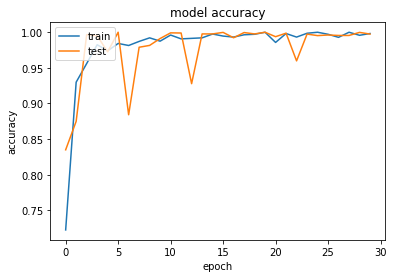

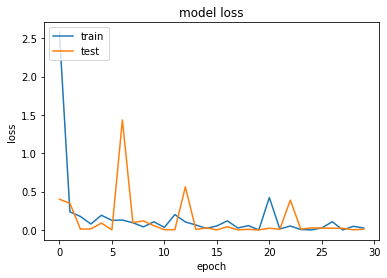

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
_, train_ims, test_ims = load_dataset_images()

train_ims = { category: [ image for collection in collections for image in collection ] for category, collections in train_ims.items() }
test_ims = { category: [ image for collection in collections for image in collection ] for category, collections in test_ims.items() }

ims = []
labels = []

for category, images in train_ims.items():
    ims.extend(images)
    labels.extend([category for _ in range(len(images))])

for category, images in test_ims.items():
    ims.extend(images)
    labels.extend([category for _ in range(len(images))])

ims = np.array([img_to_array(load_img(image)) for collection in train_dataset.values() for image in ims])

expected = model.predict(ims, verbose=2)